# Autoregressive Flow - 2D

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(100000 - 2 * count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

### Sample data

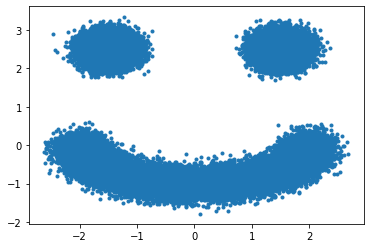

In [3]:
x, y = sample_data()
plt.scatter(x[:, 0], x[:, 1], marker='.')

x_train = x[:int(len(x) * 0.8)]
x_test = x[int(len(x) * 0.8):]

## Autoregressive Flow built out of univariate mixture CDFs

In [4]:
class MaskedLinear(nn.Linear):
    
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias=bias)
        self.register_buffer("mask", torch.ones([out_features, in_features]).float())
        
    def set_mask(self, mask):
        self.mask = mask.data
        
    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)
    
    
class PiNet(nn.Module):
    """
    MADE with one hidden layer。
    Takes x as input and output mixture coefficients of the Gaussian mixture model(GMM).
    """
    def __init__(self, k, hidden_size):
        super(PiNet, self).__init__()
        self.k = k
        self.h = hidden_size
        
        self.linear1 = MaskedLinear(2, self.h)
        mask1 = np.ones([self.h, 2], dtype=np.float32)
        mask1[:, 1] = 0.0
        self.linear1.set_mask(torch.from_numpy(mask1))
        
        self.linear2 = MaskedLinear(self.h, 2 * k)
        mask2 = np.ones([2 * k, self.h], dtype=np.float32)
        mask2[:k, :] = 0.0
        self.linear2.set_mask(torch.from_numpy(mask2))
        
    def forward(self, x):
        """
        Return
            out: Mixture coefficients.
                 out[:, 0, i] and out[:, 1, i] correspond to pi_{1, i} and pi_{2, i} in Eq. (1)~(3).
        """
        h = F.relu(self.linear1(x))
        out = self.linear2(h)
        out = out.reshape([-1, 2, self.k])
        out = F.softmax(out, dim=2)
        return out
    
    
class MuNet(nn.Module):
    
    def __init__(self, k, hidden_size):
        """
        MADE with one hidden laye.
        Takes x as input and output mean of different components of the Gaussian mixture model.
        """
        super(MuNet, self).__init__()
        self.k = k
        self.h = hidden_size
        
        self.linear1 = MaskedLinear(2, self.h)
        mask1 = np.ones([self.h, 2], dtype=np.float32)
        mask1[:, 1] = 0.0
        self.linear1.set_mask(torch.from_numpy(mask1))
        
        self.linear2 = MaskedLinear(self.h, 2 * k)
        mask2 = np.ones([2 * k, self.h], dtype=np.float32)
        mask2[:k, :] = 0.0
        self.linear2.set_mask(torch.from_numpy(mask2))
        
    def forward(self, x):
        """
        Return
            out: Mean of different components of the GMM model. 
                 out[:, 0, i] and out[:, 1, i] correspond to mu_{1, i} and mu_{2, i} in Eq. (1)~(3).
        """
        out = self.linear2(F.relu(self.linear1(x)))
        return out.view([-1, 2, self.k])
    
class VarNet(nn.Module):

    def __init__(self, k, hidden_size):
        """
        MADE with one hidden laye.
        Takes x as input and output variance of different components of the Gaussian mixture model.
        """
        super(VarNet, self).__init__()
        self.k = k
        self.h = hidden_size
        
        self.linear1 = MaskedLinear(2, self.h)
        mask1 = np.ones([self.h, 2], dtype=np.float32)
        mask1[:, 1] = 0.0
        self.linear1.set_mask(torch.from_numpy(mask1))
        
        self.linear2 = MaskedLinear(self.h, 2 * k)
        mask2 = np.ones([2 * k, self.h], dtype=np.float32)
        mask2[:k, :] = 0.0
        self.linear2.set_mask(torch.from_numpy(mask2))
        
    def forward(self, x):
        """
        Return
            out: Variance of different components of the GMM model. 
                 out[:, 0, i] and out[:, 1, i] correspond to sigma^2_{1, i} and sigma^2_{2, i} in Eq. (1)~(3).
        """
        out =  torch.exp(self.linear2(F.relu(self.linear1(x))))
        return out.view([-1, 2, self.k])


In [5]:
def getNLL(x, piNetNet, muNet, varNet):
    pi = piNetNet(x)
    mu = muNet(x)
    var = varNet(x)

    weighted_density = pi * (torch.exp(- torch.pow(x.unsqueeze(2) - mu, 2) / (2 * var)) / torch.sqrt(2 * np.pi * var))
    density = torch.sum(weighted_density, dim=2)
    abs_det = torch.log(torch.abs(density[:, 0] * density[:, 1]))
    return -abs_det

def getDensity(x, piNet, muNet, varNet):
    nll = getNLL(x, piNet, muNet, varNet).detach()
    return torch.exp(-nll)

def getLatent(x, piNet, muNet, varNet):
    pi = piNet(x)
    mu = muNet(x)
    var = varNet(x)
    # Use error function to calcuate cdf of gaussian distribution.
    z = torch.sum(pi * (torch.erf((x.unsqueeze(2) - mu) / torch.sqrt(2 * var)) + 1) * 0.5, dim=2)
    return z

In [6]:
k = 10
piNet = PiNet(k, 100).cuda()
muNet = MuNet(k, 100).cuda()
varNet = VarNet(k, 100).cuda()
lr = 1e-3

pi_optim = optim.Adam(piNet.parameters(), lr=lr)
mu_optim = optim.Adam(muNet.parameters(), lr=lr)
var_optim = optim.Adam(varNet.parameters(), lr=lr)

n_epochs = 10
batch_size = 125
n_iter_per_epoch = x_train.shape[0] // batch_size
val_steps = n_iter_per_epoch // 8

train_log = []
val_log = []
global_step = 0

for epoch in range(n_epochs):
    idx = np.random.permutation(x_train.shape[0])
    for i in range(n_iter_per_epoch):
        batch = torch.from_numpy(x_train[idx[i * batch_size: (i + 1) * batch_size], :]).float().cuda()
        
        nll = getNLL(batch, piNet, muNet, varNet)
        loss = torch.sum(nll)
        
#         print("Epoch-{:d}/{:d} Iter-{:d}/{:d}: Loss-{:.5f}".format(epoch + 1, n_epochs, i + 1, n_iter_per_epoch, loss.item()))
        
        pi_optim.zero_grad()
        mu_optim.zero_grad()
        var_optim.zero_grad()
        
        loss.backward()
        
        pi_optim.step()
        mu_optim.step()
        var_optim.step()
        
        train_nll = loss.detach() / (batch_size * 2 * np.log(2))
        train_log.append(train_nll.item())
        
        global_step += 1
        
        # Validation
        if (global_step % val_steps == 0):
            val_nll = torch.mean(getNLL(torch.from_numpy(x_test).float().cuda(), piNet, muNet, varNet).detach())
            val_nll = val_nll / (2 * np.log(2))
            val_log.append(val_nll.item())


### Negative log likelihood during training

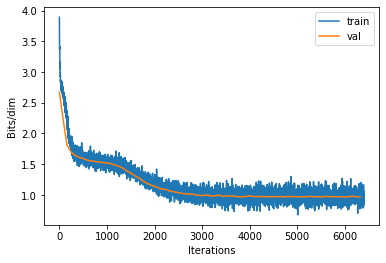

In [7]:
plt.plot(np.arange(len(train_log)), train_log, label="train")
plt.plot([i * 80 for i in np.arange(len(val_log))], val_log, label="val")
plt.xlabel("Iterations")
plt.ylabel("Bits/dim")
plt.legend()

In [8]:
nll = getNLL(torch.from_numpy(x_test).float().cuda(), piNet, muNet, varNet).detach()
nll = torch.sum(nll)
bits_per_dim = nll / x_test.shape[0] / 2 / np.log(2)
print("Test set performance: {:.5f} bits/dim".format(bits_per_dim.item()))

Test set performance: 0.97021 bits/dim


### learned density over $(-4, 4)^2$

In [10]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float().cuda()
pdf = getDensity(samples, piNet, muNet, varNet).cpu().data.numpy().reshape(100, 100)

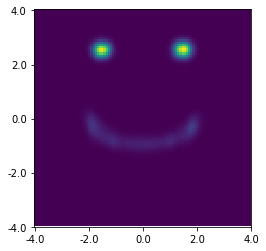

In [11]:
plt.imshow(np.rot90(pdf, 1))
_ = plt.xticks(np.linspace(0, 100, 5), np.linspace(-4, 4, 5))
_ = plt.yticks(np.linspace(0, 100, 5), np.linspace(4, -4, 5))

### Latents for data

In [12]:
z = getLatent(torch.from_numpy(x).float().cuda(), piNet, muNet, varNet)
z = z.data.cpu().data.numpy()

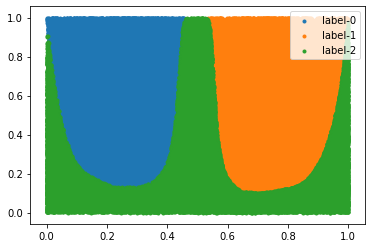

In [13]:
plt.figure()
plt.scatter(z[y == 0, 0], z[y == 0, 1], marker='.', label='label-0')
plt.scatter(z[y == 1, 0], z[y == 1, 1], marker='.', label='label-1')
plt.scatter(z[y == 2, 0], z[y == 2, 1], marker='.', label='label-2')
plt.legend(loc="upper right")

### Grid mapping

In [14]:
dx = np.linspace(-4, 4, 10)
dy = np.linspace(-4, 4, 1000)

In [15]:
grid_v = np.array(np.meshgrid(dx, dy)).T.reshape([-1, 2])
grid_h = np.array(np.meshgrid(dy, dx)).T.reshape([-1, 2])
grid = np.concatenate([grid_v, grid_h], axis=0)

In [16]:
mapped_grid = getLatent(torch.from_numpy(grid).float().cuda(), piNet, muNet, varNet)
mapped_grid = mapped_grid.cpu().data.numpy()

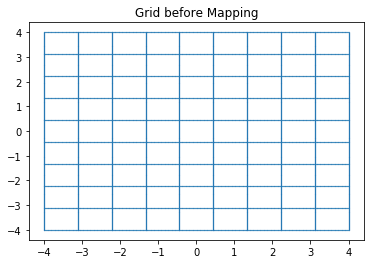

In [17]:
plt.scatter(grid[:, 0], grid[:, 1], marker='.', s=0.1)
_ = plt.title("Grid before Mapping")

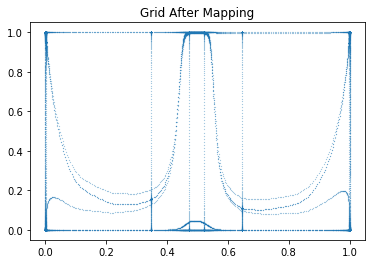

In [18]:
plt.scatter(mapped_grid[:, 0], mapped_grid[:, 1], marker='.', s=0.1)
_ = plt.title("Grid After Mapping")